In [1]:
import sys
sys.path.append('/Users/jinchen/Desktop/DSE/IntroML/Project/project-product-price-prediction')

In [56]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
matplotlib.rcParams['figure.figsize'] = (15, 15)
plt.rcParams['figure.constrained_layout.use'] = True

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from final.feature_extraction.clean_text import *
from final.feature_encoding.one_hot_encoding import one_hot_encode_feature
from final.feature_extraction.extract_text_info import extract_general_row_info, extract_row_word_counts
from final.model_evaluation.classification_model_evaluation import train_classification_model
from final.model_evaluation.visualizations import visualize_model_feature_importances, visualize_2d_cluster_with_legend


In [3]:
df = pd.read_csv("../../data/random_samples/stratified_sampling_data_by_brand_name_sz50000_1619216594.csv")
df.shape

(50000, 10)

# Encode Brand Name

In [4]:
encode_df, encode_col = one_hot_encode_feature(df, encode_column='brand_name',drop_first=False)
encode_df.shape

(50000, 573)

In [5]:
encode_df.head(5)

,train_id,name,item_condition_id,price,shipping,item_description,c1,c2,c3,brand_name_7 For All Mankind®,...,brand_name_eos,brand_name_kate spade new york,brand_name_l.e.i.,brand_name_lululemon athletica,brand_name_patagonia,brand_name_rag & bone,brand_name_rue,brand_name_theBalm,brand_name_tokidoki,brand_name_vineyard vines
0,137239,Pink Croc Sandals,3,9.0,0,"Pink Croc Sandals. The are well loved, but sti...",women,shoes,sandals,0,...,0,0,0,0,0,0,0,0,0,0
1,1196468,G-Shock Watch,3,37.0,0,Good Condition,men,men's accessories,watches,0,...,0,0,0,0,0,0,0,0,0,0
2,1086387,Dolce And Gabbana dress shirt,3,39.0,0,D&G dress shirt in great condition. Bought and...,men,tops,dress shirts,0,...,0,0,0,0,0,0,0,0,0,0
3,1440270,C.J Beathard 49ers Autograph Card,2,25.0,1,San Francisco 49ers 2017 Draft Pick C.J Beatha...,vintage & collectibles,trading cards,sports,0,...,0,0,0,0,0,0,0,0,0,0
4,1083187,O'Neill bikini top,1,13.0,1,Super cute and fashionable. Great for the beac...,women,swimwear,two-piece,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
encode_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 573 entries, train_id to brand_name_vineyard vines
dtypes: float64(1), int64(3), object(5), uint8(564)
memory usage: 30.3+ MB


# Extract Item Name Features

In [7]:
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')
num_of_processes  = 8
col_name = 'name'
clean_col_name = "clean_%s" % col_name

df = parallelize(encode_df, partial(extract_counts, col_name=col_name, prefix="bef"), num_of_processes)
df = parallelize(encode_df, partial(extract_info, col_name=col_name, stop_words=stop_words), num_of_processes)

progress-bar: 100%|██████████| 6250/6250 [00:42<00:00, 146.98it/s]

progress-bar: 100%|██████████| 6250/6250 [01:11<00:00, 87.92it/s]


# Split Train Test

In [8]:
X = df.select_dtypes(include=['int64']).drop(columns=list(encode_col)+['train_id'])
x_col = X.columns
X['name'] = df['name']
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   item_condition_id  50000 non-null  int64 
 1   shipping           50000 non-null  int64 
 2   upper_word_count   50000 non-null  int64 
 3   upper_char_count   50000 non-null  int64 
 4   stopword_count     50000 non-null  int64 
 5   punctuation_count  50000 non-null  int64 
 6   number_count       50000 non-null  int64 
 7   name               50000 non-null  object
dtypes: int64(7), object(1)
memory usage: 3.1+ MB


In [9]:
y = encode_df[encode_col]
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 564 entries, brand_name_7 For All Mankind® to brand_name_vineyard vines
dtypes: uint8(564)
memory usage: 26.9 MB


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y.values, 
                                                    test_size=0.30, random_state=42, stratify = y)

# Vectorization of Item Name

In [25]:
num_features = 20
tv = TfidfVectorizer(max_features=num_features)
train_name_feature = tv.fit_transform(X_train.name.to_list())

train_name_feature.toarray().shape

(35000, 20)

In [26]:
X_train = np.concatenate((train_name_feature.toarray(), X_train[x_col].values),axis=1)
X_test = np.concatenate((tv.transform(X_test.name.to_list()).toarray(), X_test[x_col].values),axis=1)

In [27]:
names = tv.get_feature_names()
names

['and',
 'black',
 'boots',
 'bundle',
 'dress',
 'for',
 'free',
 'jacket',
 'jeans',
 'men',
 'new',
 'nwt',
 'set',
 'shirt',
 'shorts',
 'size',
 'sz',
 'top',
 'white',
 'women']

In [28]:
x_tf_names = ['tf%02d_%s'%(i,names[i-1]) for i in range(1, num_features+1)]
x_tf_names += list(x_col)

# Classification - Random Forest

In [78]:
rf_model, y_train, y_test, y_train_pred, y_test_pred = train_classification_model(RandomForestClassifier(n_estimators=50), 
                                                              X_train, X_test, y_train, y_test,
                                                             target_classname = encode_col)

Train Accuracy: 0.34594285714285716

Top 5 class with highest train accuracy
brand_name_Free People         - 0.88710
brand_name_7 For All Mankind®  - 0.82258
brand_name_White House Black Market - 0.80645
brand_name_Miss Me             - 0.79365
brand_name_New Balance         - 0.79032

Top 5 class with lowest train accuracy
brand_name_Younique            - 0.03226
brand_name_bareMinerals        - 0.06452
brand_name_Hard Candy          - 0.09524
brand_name_Pampered Chef       - 0.09677
brand_name_Tommee Tippee       - 0.09677
--------------------------------------------------
--------------------------------------------------

Test Accuracy: 0.031466666666666664

Top 5 class with highest test accuracy
brand_name_Free People         - 0.65385
brand_name_Bonne Bell          - 0.59259
brand_name_7 For All Mankind®  - 0.55556
brand_name_White House Black Market - 0.33333
brand_name_Miss Me             - 0.30769

Top 5 class with lowest test accuracy
brand_name_LEGO                - 0.00000

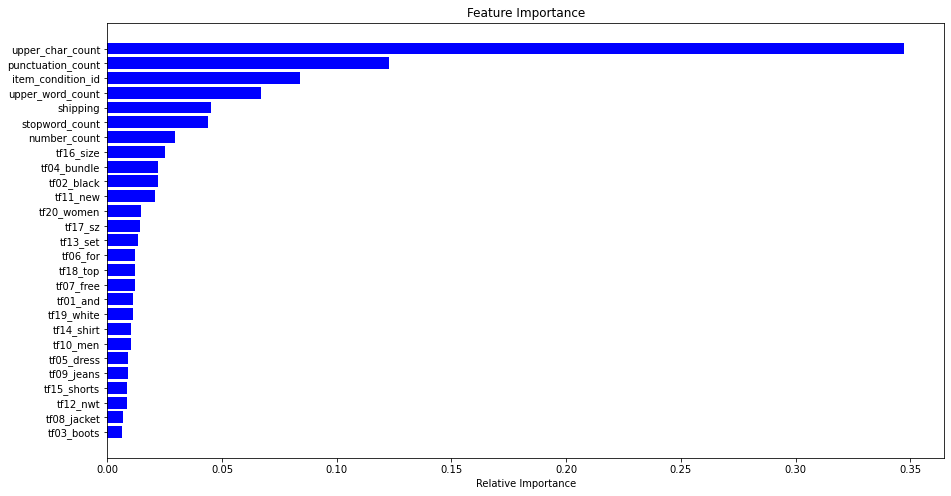

In [31]:
feature_importances = visualize_model_feature_importances(rf_model, x_tf_names, title = "Feature Importance")

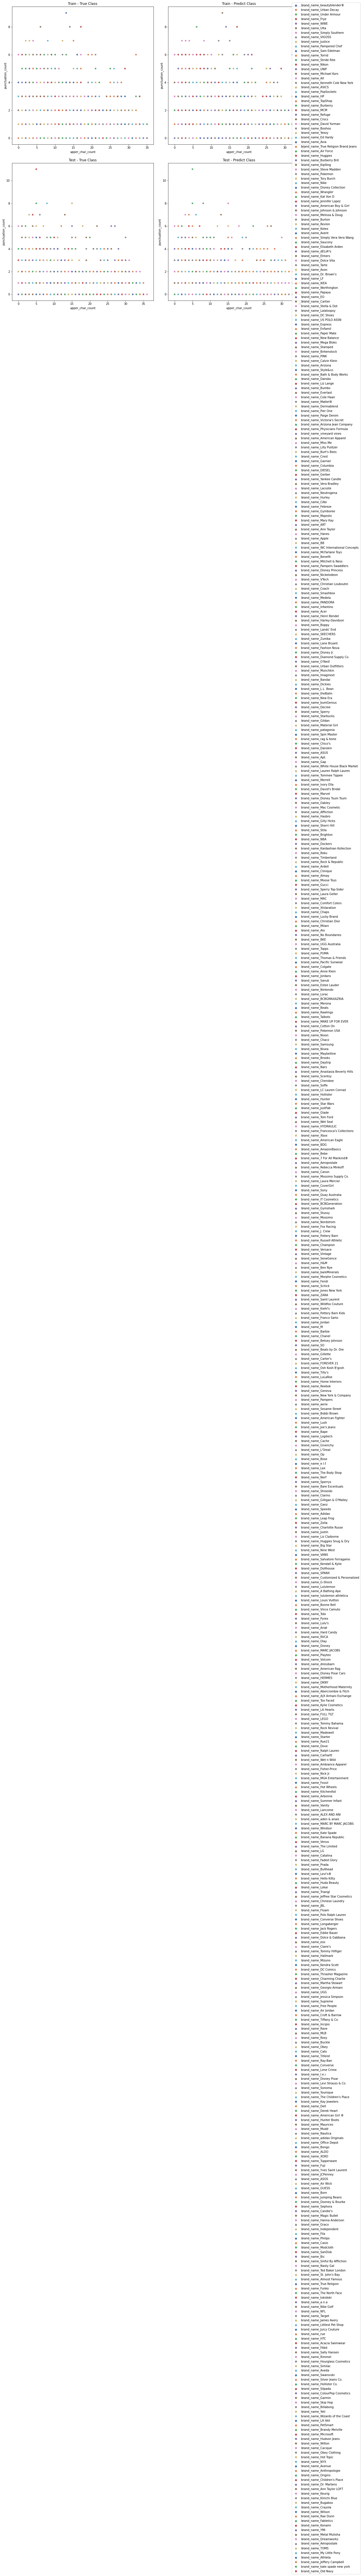

In [60]:
visualize_2d_cluster_with_legend('brand_name', feature_importances[0][0], feature_importances[1][0], 
                                 x_tf_names, encode_col, X_train, X_test, 
                                 y_train, y_test, y_train_pred,y_test_pred)

# Classification - Logistic Regression

In [79]:
lr_model, y_train, y_test, y_train_pred, y_test_pred = train_classification_model(LogisticRegression(max_iter=500), 
                                                             X_train, X_test, y_train, y_test,
                                                             target_classname = encode_col)

Train Accuracy: 0.0508

Top 5 class with highest train accuracy
brand_name_Free People         - 0.74194
brand_name_New Balance         - 0.74194
brand_name_Bonne Bell          - 0.69355
brand_name_Miss Me             - 0.65079
brand_name_7 For All Mankind®  - 0.64516

Top 5 class with lowest train accuracy
brand_name_LEGO                - 0.00000
brand_name_Metal Mulisha       - 0.00000
brand_name_Merona              - 0.00000
brand_name_Mega Bloks          - 0.00000
brand_name_Medela              - 0.00000
--------------------------------------------------
--------------------------------------------------

Test Accuracy: 0.03986666666666667

Top 5 class with highest test accuracy
brand_name_Free People         - 0.84615
brand_name_Bonne Bell          - 0.74074
brand_name_New Balance         - 0.61538
brand_name_Rae Dunn            - 0.59259
brand_name_Miss Me             - 0.57692

Top 5 class with lowest test accuracy
brand_name_LEGO                - 0.00000
brand_name_Nasty Gal   

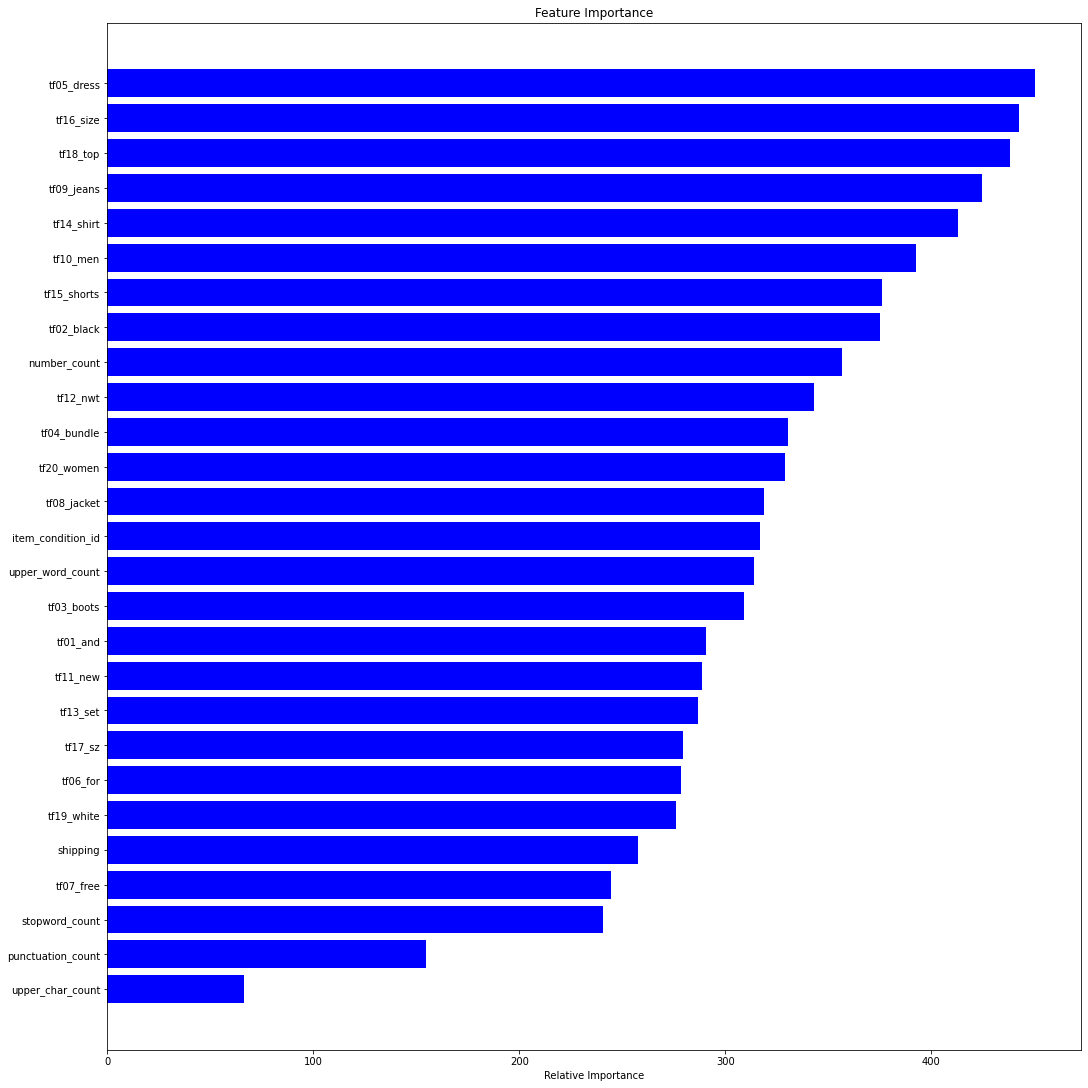

In [81]:
feature_importances = visualize_model_feature_importances(lr_model, x_tf_names, title = "Feature Importance")

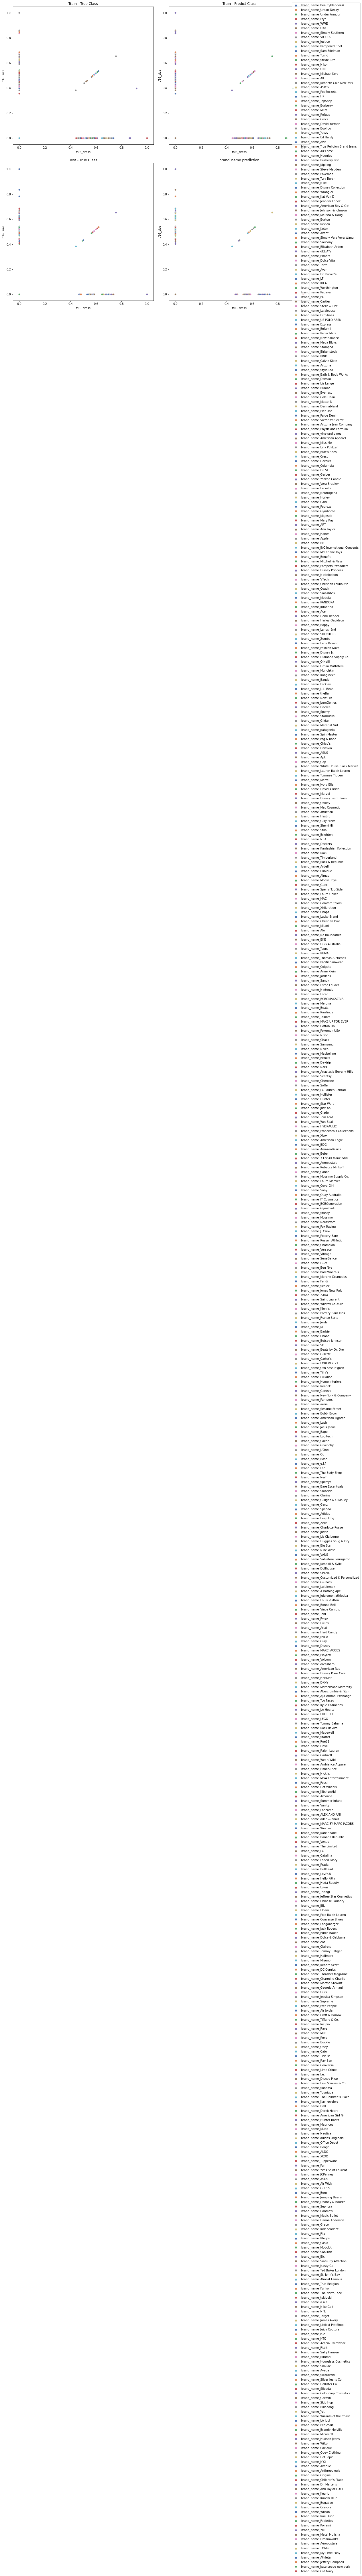

In [83]:
visualize_2d_cluster_with_legend('brand_name', feature_importances[0][0], feature_importances[1][0], 
                                 x_tf_names, encode_col, X_train, X_test, 
                                 y_train, y_test, y_train_pred,y_test_pred,
                                legend = True, title = "brand_name prediction")